# Backtest all models to obtain a realistic pnl for each

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import os

# Set Start & Finish dates for Backtest period
startDate = dt.datetime(2001, 6, 8)
finishDate = dt.datetime(2015, 5, 4)

# Load daily closing prices for SPY, using'Date' column as DataFrame index & parsing trade dates to datetime objects 
data = pd.read_csv(r'price_data\SPY.csv',index_col="Date",parse_dates=True)

# define a specic dataframe
df_SP = pd.DataFrame(data['SPY'][(data.index >= startDate) & (finishDate >= data.index)])
df_SP.head()

,SPY
Date,
2001-06-08,127.00
2001-06-11,126.10
2001-06-12,125.88
2001-06-13,124.80
2001-06-14,122.00


### Calculate Returns & pnl for "Buy & Hold" SPY strategy

In [4]:
# Calculate daily % returns of SPY and show the cumulative (compounded) returns over time 
df_SP['% Change'] = df_SP['SPY'].pct_change()
df_SP['cum_rets'] = (1 + df_SP['SPY'].pct_change()).cumprod()

df_SP.head()

,SPY,% Change,cum_rets
Date,,,
2001-06-08,127.00,NaN,NaN
2001-06-11,126.10,-0.007087,0.992913
2001-06-12,125.88,-0.001745,0.991181
2001-06-13,124.80,-0.008580,0.982677
2001-06-14,122.00,-0.022436,0.960630


#### SPY Annualized Returns, Volatility & Sharpe Ratio

In [5]:
# Calculate Annualized SPY returns & volatility from "Buy & Hold" daily % returns 
SPY_mean = df_SP['% Change'].mean()*252
SPY_vol = df_SP['% Change'].std()*np.sqrt(252)

# Calculate Annualized Sharpe ratio for "Buy & Hold" SPY strategy
SPY_sharpe = SPY_mean / SPY_vol

# Output Annualized returns & Sharpe ratio
print('SPY(Buy & Hold) mean: ', SPY_mean, '\nSPY(Buy & Hold) sharpe: ', SPY_sharpe)

SPY(Buy & Hold) mean:  0.056582911178139746 
SPY(Buy & Hold) sharpe:  0.283690268686


In [6]:
df_SP['cum_rets'].describe()

count    3495.000000
mean        1.018656
std         0.237576
min         0.536299
25%         0.869252
50%         0.974961
75%         1.118504
max         1.669213
Name: cum_rets, dtype: float64

#### Plot Cumulative SPY "Buy & Hold" returns  

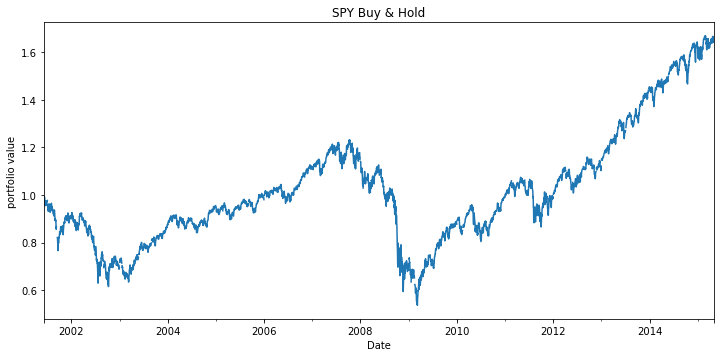

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 12

ax1 = plt.subplot(211)
df_SP['cum_rets'].plot(ax=ax1)
ax1.set_ylabel('portfolio value')
plt.title('SPY Buy & Hold')

### Calculate pnl for Cash holdings (T-Bill - 30bps)

In [8]:
import pandas_datareader as web

#get the risk free rate (3 Month T-Bills)
rf_yearly = pd.DataFrame(web.DataReader("TB3MS", "fred", start=startDate, end=finishDate)['TB3MS'])

rf_yearly['TB3MS'] = rf_yearly['TB3MS'] - 0.30
rf_d = (rf_yearly.asfreq('D').fillna(method='pad'))/(365*100)

rf = rf_d.iloc[2:].resample('B').ffill()

rf.head()

,TB3MS
DATE,
2001-07-03,0.000088
2001-07-04,0.000088
2001-07-05,0.000088
2001-07-06,0.000088
2001-07-09,0.000088


In [9]:
# Calculate daily % returns of risk-free rate (3 Month T-Bills - 30 bps) & show cumulative (compounded) returns over time 
rf['% Change'] = (1 + rf['TB3MS'].iloc[1:]).cumprod()

rf.head()

,TB3MS,% Change
DATE,,
2001-07-03,0.000088,NaN
2001-07-04,0.000088,1.000088
2001-07-05,0.000088,1.000176
2001-07-06,0.000088,1.000264
2001-07-09,0.000088,1.000352


#### Plot Cumulative SPY "Buy & Hold" returns vs Cash  

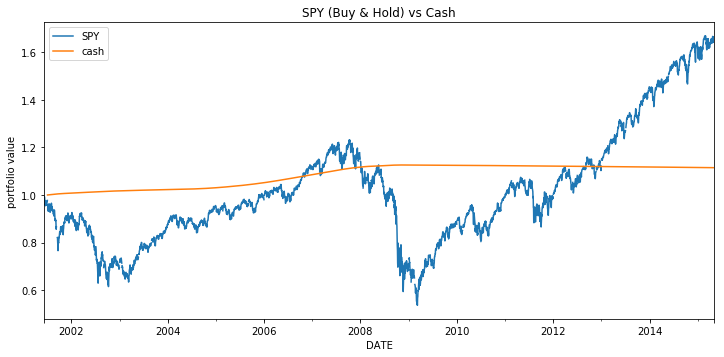

In [10]:
ax1 = plt.subplot(211)
df_SP['cum_rets'].plot(ax=ax1, label='SPY')
ax1.set_ylabel('portfolio value')
plt.title('SPY (Buy & Hold) vs Cash')

ax2 = plt.subplot(211)
rf['% Change'].plot(ax=ax2, label='cash')

plt.legend(loc=0)

### Model Backtests - Predicted Returns

#### Define function to calculate Annulaized returns & sharpe by specific Timeframe/Model/Model Version

In [11]:
def calculate_mean_sharpe(mycol):
    mult = 8
    mypos = (mycol * mult).round(1).clip(-0.5,1.5)
    prctgChange = df_SP['% Change'] * mypos.shift(1)
    cumChange = (1 + prctgChange).cumprod()
    cumChange.head()
    simp_mean = prctgChange.mean()*252
    simp_vol = prctgChange.std()*np.sqrt(252)
    simp_sharpe = simp_mean / simp_vol
    return pd.Series({'mean': simp_mean, 'sharpe': simp_sharpe})

#### Calculate Annualized returns & sharpe for each specific Timeframe/Model/Model Version ===> output results to dataframe

In [12]:
path = 'Predicted_Return\\'
folders = os.listdir(path)
folderDict = {}
for folder in folders:
    filenames = os.listdir(os.path.join(path, folder))
    alldf = pd.DataFrame()
    for filename in filenames:
        file = os.path.join(path, folder, filename)
        method = filename.replace('PredReturn_', '').replace('.csv', '')
        if method in ['simpLR', 'LR_Trans']:
            mydf = pd.read_csv(file, names=['Date',method],index_col='Date',parse_dates=True)
        else:
            mydf = pd.read_csv(file)
            mydf = mydf.set_index(mydf.columns.values[0])
            mydf.columns = [method + '_' + x for x in mydf.columns]
        alldf = pd.concat((alldf, mydf), axis=1)
        alldf = alldf[(alldf >= startDate) & (alldf <= finishDate)]
    folderResults = alldf.apply(calculate_mean_sharpe, 0).transpose()
    folderDict[folder] = folderResults
    
finaldf = pd.concat( list(folderDict.values()), axis = 1, keys=list(folderDict.keys())) 
finaldf.head()

130_10               130_5               60_10            \
                      mean    sharpe      mean    sharpe      mean    sharpe   
LR_Trans          0.003057  0.017104  0.025528  0.156083  0.037358  0.204086   
corrLR_corr_0.05  0.023822  0.161716 -0.004258 -0.025326  0.044501  0.274586   
corrLR_corr_0.1   0.029033  0.205933  0.013237  0.080904  0.046641  0.313456   
corrLR_corr_0.15  0.008310  0.050425  0.014524  0.093096  0.028206  0.278757   
corrLR_corr_0.2  -0.007974 -0.045922  0.037944  0.239067  0.026908  0.378478   

                      60_5            
                      mean    sharpe  
LR_Trans          0.044615  0.267205  
corrLR_corr_0.05  0.027099  0.162465  
corrLR_corr_0.1   0.049595  0.328437  
corrLR_corr_0.15  0.053975  0.362404  
corrLR_corr_0.2   0.058421  0.497403

#### Display all Backtest results (Annualized returns & sharpe) by Timeframe/Model/Model Version

In [13]:
finaldf

130_10               130_5               60_10  \
                              mean    sharpe      mean    sharpe      mean   
LR_Trans                  0.003057  0.017104  0.025528  0.156083  0.037358   
corrLR_corr_0.05          0.023822  0.161716 -0.004258 -0.025326  0.044501   
corrLR_corr_0.1           0.029033  0.205933  0.013237  0.080904  0.046641   
corrLR_corr_0.15          0.008310  0.050425  0.014524  0.093096  0.028206   
corrLR_corr_0.2          -0.007974 -0.045922  0.037944  0.239067  0.026908   
corrLR_corr_0.25          0.016854  0.115776  0.028189  0.176128       NaN   
corrLR_corr_0.3           0.039266  0.292112  0.019830  0.123485       NaN   
corrLR_corr_0.35               NaN       NaN  0.028613  0.176722       NaN   
elasticNet_en_a0.1_r0.0   0.023824  0.136837 -0.002424 -0.016022  0.020065   
elasticNet_en_a0.1_r0.1   0.023405  0.150383 -0.002693 -0.019356  0.020177   
elasticNet_en_a0.1_r0.2   0.031399  0.213623  0.010413  0.079479  0.019270   
elasticNet_en_a0.1_r0.3   0.036632  0.272019  0.015214  0.120513  0.018696   
elasticNet_en_a0.1_r0.4   0.034791  0.292760  0.015061  0.121298  0.017237   
elasticNet_en_a0.1_r0.5   0.037045  0.349341  0.014625  0.119632  0.014055   
elasticNet_en_a0.1_r0.6   0.034264  0.365426  0.013206  0.109339  0.010624   
elasticNet_en_a0.1_r0.7   0.032250  0.376069  0.011297  0.095457  0.010549   
elasticNet_en_a0.1_r0.8   0.027555  0.352904  0.011991  0.102751  0.005629   
elasticNet_en_a0.1_r0.9   0.026445  0.360357  0.008391  0.073363  0.003199   
elasticNet_en_a0.1_r1.0   0.021652  0.308289  0.004393  0.039221  0.001561   
elasticNet_en_a0.2_r0.0   0.021467  0.126309 -0.003224 -0.021989  0.021170   
elasticNet_en_a0.2_r0.1   0.031589  0.215497  0.009428  0.072731  0.018907   
elasticNet_en_a0.2_r0.2   0.035191  0.297336  0.016088  0.129579  0.017517   
elasticNet_en_a0.2_r0.3   0.034093  0.363885  0.013538  0.112213  0.010408   
elasticNet_en_a0.2_r0.4   0.027162  0.348329  0.011401  0.097849  0.005247   
elasticNet_en_a0.2_r0.5   0.021278  0.302790  0.004228  0.037910  0.001511   
elasticNet_en_a0.2_r0.6   0.014071  0.216822 -0.004191 -0.040699 -0.002304   
elasticNet_en_a0.2_r0.7   0.009570  0.150503 -0.006107 -0.062139 -0.003578   
elasticNet_en_a0.2_r0.8   0.003686  0.057951 -0.011502 -0.127422 -0.003320   
elasticNet_en_a0.2_r0.9   0.003912  0.062141 -0.011154 -0.134215 -0.001298   
elasticNet_en_a0.2_r1.0   0.003390  0.054115 -0.006651 -0.084502  0.000547   
elasticNet_en_a0.3_r0.0   0.019986  0.119180 -0.002876 -0.019999  0.017904   
elasticNet_en_a0.3_r0.1   0.035874  0.270494  0.015732  0.125029  0.018236   
elasticNet_en_a0.3_r0.2   0.033713  0.360336  0.013377  0.111032  0.010756   
elasticNet_en_a0.3_r0.3   0.025672  0.351658  0.008346  0.073094  0.003051   
elasticNet_en_a0.3_r0.4   0.014099  0.217255 -0.004272 -0.041623 -0.002406   
elasticNet_en_a0.3_r0.5   0.006376  0.100357 -0.008995 -0.095226 -0.003341   
elasticNet_en_a0.3_r0.6   0.003828  0.060809 -0.010993 -0.132303 -0.001298   
elasticNet_en_a0.3_r0.7   0.001213  0.019328 -0.006064 -0.080286  0.000120   
elasticNet_en_a0.3_r0.8  -0.001717 -0.028374 -0.010548 -0.147942  0.000112   
elasticNet_en_a0.3_r0.9   0.000391  0.006944 -0.017925 -0.267532  0.001261   
elasticNet_en_a0.3_r1.0   0.003873  0.072761 -0.018656 -0.299382  0.000808   
elasticNet_en_a0.4_r0.0   0.017899  0.107240 -0.004003 -0.028248  0.018377   
elasticNet_en_a0.4_r0.1   0.037056  0.315826  0.015308  0.123657  0.017648   
elasticNet_en_a0.4_r0.2   0.027163  0.350817  0.010663  0.091857  0.004975   
elasticNet_en_a0.4_r0.3   0.014100  0.217608 -0.004802 -0.046909 -0.002425   
elasticNet_en_a0.4_r0.4   0.004021  0.063188 -0.011968 -0.133088 -0.003320   
elasticNet_en_a0.4_r0.5   0.003390  0.054115 -0.006553 -0.083578  0.000547   
elasticNet_en_a0.4_r0.6  -0.001717 -0.028374 -0.010783 -0.151269  0.000112   
elasticNet_en_a0.4_r0.7   0.002785  0.051385 -0.019279 -0.291780  0.000991   
elasticNet_en_a0.4_r0.8   0.002853  0.054389 -0.01

#### Define function to call specific Timeframe/Model/Model Version, plot its cumulative returns & overlay baseline metrics

In [14]:
def plot_return(folderIndx, modelIndx, versionIndx):
    folders = os.listdir(path)
    folder = folders[folderIndx]
    filenames = os.listdir(os.path.join(path,folder))
    filename = filenames[modelIndx]
    
    file = os.path.join(path, folder, filename)
    method = filename.replace('PredReturn_', '').replace('.csv', '')
    if method in ['simpLR', 'LR_Trans']:
        mydf = pd.read_csv(file, names=['Date',method],index_col='Date',parse_dates=True)
    else:
        mydf = pd.read_csv(file)
        mydf = mydf.set_index(mydf.columns.values[0])
        mydf.columns = [method + '_' + x for x in mydf.columns]
    mydf = mydf[(mydf >= startDate) & (mydf <= finishDate)]
    version = mydf.columns[versionIndx]
    mycol = mydf.iloc[:,versionIndx]
    mult = 8
    mypos = (mycol * mult).round(1).clip(-0.5,1.5)
    prctgChange = df_SP['% Change'] * mypos.shift(1)
    
    # OUTPUT TIME SERIES OF DAILY RETURNS (Additional check for data & calculation accuracy)
    prctgChange.to_csv(r'price_data\test.csv')    
    
    cumChange = (1 + prctgChange).cumprod()
    cumChange.head()
    simp_mean = prctgChange.mean()*252
    simp_vol = prctgChange.std()*np.sqrt(252)
    simp_sharpe = simp_mean / simp_vol
    
    ax1 = plt.subplot(211)
    df_SP['cum_rets'].plot(ax=ax1, label='SPY')
    ax1.set_ylabel('portfolio value')
    plt.title('SPY (Buy & Hold) vs {0} ({1})'.format(version,folder))

    ax2 = plt.subplot(211)
    rf['% Change'].plot(ax=ax2, label='cash')

    ax3 = plt.subplot(211)
    cumChange.plot(ax=ax3, label=method)
    plt.legend(loc=0)
    plt.xlim([df_SP.index.min(), df_SP.index.max()])
    
    print('backtest mean: ', simp_mean, '\nbacktest sharpe: ', simp_sharpe)

#### Plot cumulative returns for a specific backtest against SPY "Buy & Hold", Cash

In [2]:
# BE SURE TO SPECIFY: (Predicted Fwd. Return/Lookback Period, Model, Model Version)
plot_return(3, 3, 3)

NameError: name 'os' is not defined